In [1]:
import pandas as pd
import numpy as np
import yfinance as yfin
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from keras_tuner import HyperModel, RandomSearch

In [2]:
def verificarEstacionariedade(df):
    resultado = adfuller(df['Adj Close'])
    print('Estatísticas ADF:', resultado[0])
    print('Valor p:', resultado[1])
    print('Número de lags utilizados:', resultado[2])
    print('Número de observações utilizadas para ADF:', resultado[3])
    print('Valores críticos:')
    for key, value in resultado[4].items():
        print(f'\t{key}: {value}')
    if resultado[1] <= 0.05:
        print("A série é estacionária (rejeitamos a hipótese nula).")
    else:
        print("A série não é estacionária (não rejeitamos a hipótese nula).")


In [3]:
def carregarDados(ticket, start_date, end_date):
    data = yfin.download(tickers=ticket, start=start_date, end=end_date)
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(data['Adj Close'].values.reshape(-1,1))
    return data, scaled_data, scaler

In [4]:
def prepararDadosTreinamento(scaled_data, days):
    x_train, y_train = [], []
    for i in range(days, len(scaled_data)):
        x_train.append(scaled_data[i-days:i, 0])
        y_train.append(scaled_data[i, 0])
    return np.array(x_train).reshape(-1, days, 1), np.array(y_train)


In [5]:
class LSTMHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        model = Sequential()
        model.add(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32), 
                       return_sequences=True, 
                       input_shape=self.input_shape))
        model.add(Dropout(hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
        model.add(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32), return_sequences=True))
        model.add(Dropout(hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
        model.add(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32)))
        model.add(Dropout(hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
        model.add(Dense(units=1, activation='tanh'))
        
        model.compile(optimizer='adam', loss='mean_squared_error')
        return model

In [6]:
def modeloLSTM(input_shape):
    model = Sequential([
        LSTM(units=50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(units=50, return_sequences=True),
        Dropout(0.2),
        LSTM(units=50),
        Dropout(0.2),
        Dense(units=1, activation='tanh')
    ])
    return model

In [7]:
def treinarModelo(model, x_train, y_train, epochs=50, batch_size=32):
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
    return model

In [8]:
def avaliarModelo(model, x_test, y_test, scaler):
    predicted_scaled = model.predict(x_test)
    #predicted = scaler.inverse_transform(predicted_scaled)
    #actual = scaler.inverse_transform(y_test.reshape(-1,1))
    actual_scaled = y_test

    mae = mean_absolute_error(actual_scaled, predicted_scaled)
    mse = mean_squared_error(actual_scaled, predicted_scaled)
    rmse = np.sqrt(mse)
    r2 = r2_score(actual_scaled, predicted_scaled)
    
    return mae, mse, rmse, r2, actual_scaled, predicted_scaled

In [9]:
def plotarESalvarGrafico(actual, predicted, ticket, days, fold):
    plt.figure(figsize=(14, 7))
    plt.plot(actual, color='black', label=f'Preços Reais da {ticket}')
    plt.plot(predicted, color='green', label=f'Preços Previstos da {ticket}')
    plt.title(f'{ticket} - Janela: {days} dias - Fold: {fold+1}')
    plt.xlabel('Tempo')
    plt.ylabel(f'{ticket}')
    plt.legend()
    plt.savefig(f'prediction_plot_{days}_days_fold_predicted{fold+1}.png')
    plt.show()


In [10]:
def plotarESalvarGrafico2(actual, predicted, ticket, days, fold):
    plt.figure(figsize=(14, 7))
    plt.plot(actual, color='black', label=f'Preços Reais da {ticket}')
    plt.plot(predicted, color='green', label=f'Preços Previstos da {ticket}')
    plt.title(f'{ticket} - Janela: {days} dias - Fold: {fold+1}')
    plt.xlabel('Tempo')
    plt.ylabel(f'{ticket}')
    plt.legend()
    plt.savefig(f'prediction_plot_{days}_days_fold_actual{fold+1}.png')
    plt.show()

In [11]:
def salvarResultadosCSV(resultados, filename='model_performance_all_kfold_avg.csv'):
    all_results_df = pd.DataFrame(resultados)
    all_results_df.to_csv(filename, index=False)


In [12]:
def executarModelo(ticket, scaled_data, scaler, max_days=21):
    all_fold_results = []
    tscv = TimeSeriesSplit(n_splits=5)
    
    for days in range(1, max_days):
        x_train, y_train = prepararDadosTreinamento(scaled_data, days)
        
        fold_mae, fold_mse, fold_rmse, fold_r2 = [], [], [], []
        
        for fold, (train_idx, test_idx) in enumerate(tscv.split(x_train)):
            x_train_fold, x_val_fold = x_train[train_idx], x_train[test_idx]
            y_train_fold, y_val_fold = y_train[train_idx], y_train[test_idx]

            tuner = RandomSearch(
                LSTMHyperModel(input_shape=(x_train.shape[1], 1)),
                objective='val_loss',
                max_trials=10,
                executions_per_trial=1,
                directory='my_dir',
                project_name='lstm_tuning'
            )

            tuner.search(x_train_fold, y_train_fold, epochs=50, validation_data=(x_val_fold, y_val_fold))
            best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
            model = tuner.hypermodel.build(best_hps)
            model.fit(x_train_fold, y_train_fold, epochs=50, batch_size=32, validation_data=(x_val_fold, y_val_fold))


            #model = modeloLSTM(input_shape=(x_train.shape[1], 1))
            #model = treinarModelo(model, x_train_fold, y_train_fold)
            mae, mse, rmse, r2, actual, predicted = avaliarModelo(model, x_val_fold, y_val_fold, scaler)

            fold_mae.append(mae)
            fold_mse.append(mse)
            fold_rmse.append(rmse)
            fold_r2.append(r2)

            plotarESalvarGrafico(actual, predicted, ticket, days, fold)

            all_fold_results.append({
                'Days': days,
                'Fold': fold+1,
                'Avg MAE': np.mean(fold_mae),
                'Avg MSE': np.mean(fold_mse),
                'Avg RMSE': np.mean(fold_rmse),
                'Avg R²': np.mean(fold_r2)
            })

    salvarResultadosCSV(all_fold_results)


In [13]:
ticket = "PETR4.SA"
data, scaled_data, scaler = carregarDados(ticket, start_date=datetime(2005, 1, 1), end_date=datetime(2021, 1, 1))
verificarEstacionariedade(data)
dataDiff = data.diff().dropna()
dataLog = np.log(data)

verificarEstacionariedade(dataDiff)
verificarEstacionariedade(dataLog)
scaled_data_diff = scaler.fit_transform(dataDiff['Adj Close'].values.reshape(-1,1))


[*********************100%%**********************]  1 of 1 completed
c:\Users\leona\anaconda3\envs\ambiente\Lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


Estatísticas ADF: -2.661497410254255
Valor p: 0.08094113470034253
Número de lags utilizados: 12
Número de observações utilizadas para ADF: 3964
Valores críticos:
	1%: -3.432000741590981
	5%: -2.862269407331276
	10%: -2.567158271601324
A série não é estacionária (não rejeitamos a hipótese nula).
Estatísticas ADF: -17.664217853742976
Valor p: 3.670092054882776e-30
Número de lags utilizados: 11
Número de observações utilizadas para ADF: 3964
Valores críticos:
	1%: -3.432000741590981
	5%: -2.862269407331276
	10%: -2.567158271601324
A série é estacionária (rejeitamos a hipótese nula).
Estatísticas ADF: -2.7940305503210587
Valor p: 0.059131533773051005
Número de lags utilizados: 10
Número de observações utilizadas para ADF: 3966
Valores críticos:
	1%: -3.4319999086046633
	5%: -2.8622690393645924
	10%: -2.5671580757111188
A série não é estacionária (não rejeitamos a hipótese nula).


Reloading Tuner from my_dir\lstm_tuning\tuner0.json


c:\Users\leona\anaconda3\envs\ambiente\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.2913 - val_loss: 0.0099
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0188 - val_loss: 0.0091
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0051 - val_loss: 0.0052
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0021 - val_loss: 0.0045
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0017 - val_loss: 0.0044
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018 - val_loss: 0.0045
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0016 - val_loss: 0.0044
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0015 - val_loss: 0.0044
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017 - val_loss: 0.0044
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0017 - val_loss: 0.0044
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019 - val_loss: 0.0044
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0016 - val_l

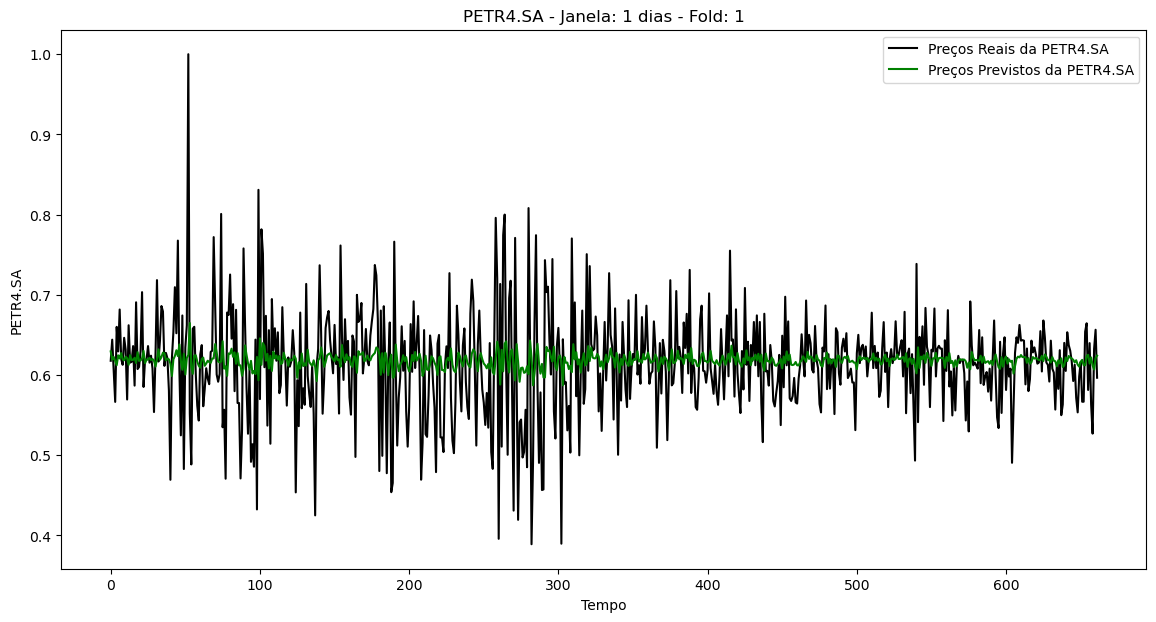

Reloading Tuner from my_dir\lstm_tuning\tuner0.json
Epoch 1/50


c:\Users\leona\anaconda3\envs\ambiente\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.2158 - val_loss: 0.0053
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0055 - val_loss: 0.0012
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0035 - val_loss: 0.0012
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0033 - val_loss: 0.0012
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0039 - val_loss: 0.0012
Epoch 6/50
 1/42 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0032

KeyboardInterrupt: 

In [14]:
executarModelo(ticket, scaled_data_diff, scaler)